# COMP0087 Project: Group 32 Second Notebook: Testing Model on Unseen Inputs

This notebook is the second one to give a way to interact with the trained model on unseen inputs.

The structure of this notebook is as follows: the first section is the one where the user may enter a custom premise, hypothesis, and label. The second section requires an upload of the model file so weights may be loaded in, and another file containing the required vocab objects for numericalisation. The third section defines all the required functions and model definitions for the script to run properly: we recommend running and collapsing this cell to keep the notebook compact visually. The fourth 'run model' section evaluates the model on the provided inputs. The fifth and final section then visualises the attention outputs of the various layers of the RNN stack of the DRCN.

## Enter Desired Premise, Hypothesis, and Label

In the following cell, provide the desired input in the first three lines.

**To rerun the model with different inputs after the initial pass over the script, simply run this cell again and then the run model cell**

Example entries:

Premise | Hypothesis | Label
--- | ---
Take back control | Leave the European Union | contradiction
Make America Great Again | Build the Wall | contradiction
May's government | Strong and stable | contradiction
Two dogs playing in the snow | There are two dogs playing together in the snow | entailment
An older and younger man smiling | Two men are smiling and laughing at the cats playing on the floor | neutral
A man reads the paper in a bar with green lighting | The man is inside | entailment

In [9]:
P = "Make America Great Again"
Q = "Build the Wall"
answer = "contradiction"

if answer not in ['entailment', 'contradiction', 'neutral']:
  print('WARNING: label is not within range of options')

P = [i.lower() for i in  P.split(' ')]
Q = [i.lower() for i in  Q.split(' ')]
p_plot = P
q_plot = Q
p_len = len(P)
q_len = len(Q)
print(P)
print(Q)

['make', 'america', 'great', 'again']
['build', 'the', 'wall']


## Upload Required Files

Please upload (a) the model file: DRCN-B-Ca-Cs-M.pt, (b) vocab_stoi.p. **Please ensure they are all located in /content/gdrive/My Drive/Group_32/**. 

The files should be uploaded via connecting Google Drive (direct upload seems to fail for files of this size)

In [2]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle

with open("/content/gdrive/My Drive/Group_32/vocab_stoi.p", "rb") as input_file:
  stoi = pickle.load(input_file)

## Prep definitions

This section preps all the necessary function and class definitions. Run and collapse for presetnation purposes.

In [4]:
# The attention functions to run. Must be a list
options = ['cosine','bilinear','minus','concat']
options = sorted(options) # alphabetical sorting


# Set file path for any model to be loaded and/or saved.
# D -> Dot
# Cs -> Cosine
# Ca -> Concat
# B -> Bilinear
# M -> Minus
attent_name = []
name_dict = {'cosine': 'Cs', 'concat': 'Ca', 'bilinear': 'B', 'minus': 'M', 'dot': 'D'}
for i in options:
  attent_name.append(name_dict[i])
attent_name = sorted(attent_name)
file_path = '/content/gdrive/My Drive/Group_32/DRCN-' + '-'.join(attent_name) + '.pt'
print('File path is: {}'.format(file_path))

batch_size = 2

"""# Import dependencies and set up file path"""
import numpy as np
import math
from pathlib import Path
import torch
import torchtext
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from collections import Counter
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
porter=PorterStemmer()

"""# Setting up data

## Define fields and read in SNLI data
"""

def remove_fullstop(sentence):
  
  if sentence[-1][-1]=='.':
    sentence[-1]= sentence[-1][:-1]
    return sentence
  else:
    return sentence

def lemmit(sentence):
  
  sentence = remove_fullstop(sentence)
  
  return [wordnet_lemmatizer.lemmatize(i, pos = 'n') for i in sentence]

def stemmer(sentence):
  
  sentence = remove_fullstop(sentence)

  return [porter.stem(i) for i in sentence]

def splitter(sentence):
  
  sentence = remove_fullstop(sentence)
  
  # expand each word into its characters
  split_list = [list(i) for i in sentence]

  # join list of lists
  split_list = list(itertools.chain.from_iterable(split_list))
  
  return split_list

def is_in_vocab(word, typ = 'default'):
  
  if typ == 'default':
      return word in stoi[0].keys()
  elif typ == 'char':
      return word in stoi[1].keys()
  elif typ == 'stem':
      return word in stoi[2].keys()
  elif typ == 'lemm':
      return word in stoi[3].keys()

# TODO: check if in vocab
def replace_oov(sentence, typ = 'default'):
  
  # if typ == 'default':
  #   temp = stoi[0]
  # elif typ == 'char':
  #   temp = stoi[1]
  # elif typ == 'stem':
  #   temp = stoi[2]
  # elif typ == 'lemm':
  #   temp = stoi[3]
  
  return [i if is_in_vocab(i, typ) else '<unk>' for i in sentence]

def numericalise(sentence, typ = 'default'):
  
  num = []
  for i in sentence:
    if typ == 'default':
      num.append(stoi[0][i])
    elif typ == 'char':
      num.append(stoi[1][i])
    elif typ == 'stem':
      num.append(stoi[2][i])
    elif typ == 'lemm':
      num.append(stoi[3][i])
  
  return torch.tensor(num).cuda().unsqueeze(0).expand(2,-1)

def make_example(P, Q, answer):
  # make into batch
  P_char = numericalise(replace_oov(splitter(P)), typ = 'char')
  Q_char = numericalise(replace_oov(splitter(Q)), typ = 'char')
  P_stem = numericalise(replace_oov(stemmer(P)), typ = 'stem')
  Q_stem = numericalise(replace_oov(stemmer(Q)), typ = 'stem')
  P_lemm = numericalise(replace_oov(lemmit(P)), typ = 'lemm')
  Q_lemm = numericalise(replace_oov(lemmit(Q)), typ = 'lemm')
  P = numericalise(replace_oov(P))
  Q = numericalise(replace_oov(Q))

  ans = torch.tensor(int(stoi[-1][answer])).cuda().unsqueeze(0).expand(2)

  example = (P, Q, P_char, Q_char, P_stem, Q_stem, P_lemm, Q_lemm, ans)

  return example


# Create batch wrapper to return the correct input for the DRCN model:

def BatchWrapper(example):

  # retrieve objects
  P = example[0]
  P_char = example[2]
  P_stem = example[4]
  P_lemm = example[6]

  Q = example[1]
  Q_char = example[3]
  Q_stem = example[5]
  Q_lemm = example[7]

  labels = example[-1]

  # detect exact match binary flag
  match_matrix_P_stem = torch.zeros(P.shape[0], P_stem.shape[1]).cuda()
  match_matrix_P_lemm = torch.zeros(P.shape[0], P_lemm.shape[1]).cuda()

  match_matrix_Q_stem = torch.zeros(Q.shape[0], Q_stem.shape[1]).cuda()
  match_matrix_Q_lemm = torch.zeros(Q.shape[0], Q_lemm.shape[1]).cuda()

  for ind in range(P.shape[0]):

    sen_p_stem = P_stem[ind, :]
    sen_p_lemm = P_lemm[ind, :]

    sen_q_stem = Q_stem[ind, :]
    sen_q_lemm = Q_lemm[ind, :]

    #remove padding
    sen_p_stem = [i.item() for i in sen_p_stem if (i != 1)]
    sen_p_lemm = [i.item() for i in sen_p_lemm if (i != 1)]

    sen_q_stem = [i.item() for i in sen_q_stem if (i != 1)]
    sen_q_lemm = [i.item() for i in sen_q_lemm if (i != 1)]

    # find intersecting elements
    intersection_stem = np.intersect1d(np.asarray(sen_p_stem), np.asarray(sen_q_stem))
    intersection_lemm = np.intersect1d(np.asarray(sen_p_lemm), np.asarray(sen_q_lemm))

    # for each intersecting element, turn the corresponding item in match_matrix to True
    for shared_element in intersection_stem:
      match_matrix_P_stem[ind, np.argwhere(sen_p_stem==shared_element)] = 1
      match_matrix_Q_stem[ind, np.argwhere(sen_q_stem==shared_element)] = 1

    for shared_element in intersection_lemm:
      match_matrix_P_lemm[ind, np.argwhere(sen_p_lemm==shared_element)] = 1
      match_matrix_Q_lemm[ind, np.argwhere(sen_q_lemm==shared_element)] = 1

  # combine the match matrices, expressing OR logical operation mathematically    
  match_matrix_P = match_matrix_P_stem + match_matrix_P_lemm - torch.mul(match_matrix_P_stem, match_matrix_P_lemm)
  match_matrix_Q = match_matrix_Q_stem + match_matrix_Q_lemm - torch.mul(match_matrix_Q_stem, match_matrix_Q_lemm)

  # reduce label by 1 so it's index-friendly
  labels = labels - 1

  return (P.cuda(), P_char.cuda(), Q.cuda(), Q_char.cuda(), match_matrix_P.cuda(), match_matrix_Q.cuda(), labels.cuda())


print('BatchWrapper defined.')


"""# Prepare model

## Define index_to_word_length to be used in character convolutions
"""

# Define function to extract relevant character embeddings:
index_to_word_length = Counter()
for key, value in stoi[0].items():
  index_to_word_length[value] = len(key)

"""## Define Attention Functions"""

class MultiAttention(nn.Module):

  def __init__(self, dimensions, options):
    super(MultiAttention, self).__init__()
        
    if not(set(options).issubset({'dot','bilinear','cosine','concat','minus'})):
      raise ValueError('Invalid attention type selected.')
    elif len(set(options))<len(options):
      raise Syntaxerror('Duplicate attention options specified')
    else:
      self.options = options
    
    # Create linear layers for the relevant options declared:
    if 'bilinear' in self.options:
      self.linear_bi = nn.Linear(dimensions, dimensions, bias=False)
    
    if 'dot' in self.options:
      self.linear_dot = nn.Linear(dimensions, dimensions, bias=False)
      self.linear_dot_out = nn.Linear(dimensions, 1, bias=False)
      
    if 'concat' in self.options:
      self.linear_cat_in = nn.Linear(2*dimensions, 2*dimensions, bias = False)
      self.linear_cat_out = nn.Linear(2*dimensions, 1, bias = False)
    
    if 'minus' in self.options:
      self.linear_minus = nn.Linear(dimensions, dimensions, bias = False)
      self.linear_minus_out = nn.Linear(dimensions, 1, bias = False)
    
    self.multiway = len(options)>1
    
    if self.multiway:
      self.lstm_agg = nn.LSTM(len(options)*dimensions, int(dimensions/2), bidirectional = True, batch_first = True)
    
    self.softmax = nn.Softmax(dim=-1)
    
    self.tanh = nn.Tanh()

  def forward(self, query, context):
    """
    Args:
        query (:class:`torch.FloatTensor` [batch size, output length, dimensions]): Sequence of
            queries to query the context.
        context (:class:`torch.FloatTensor` [batch size, query length, dimensions]): Data
            overwhich to apply the attention mechanism.

    Returns:
        :class:`tuple` with `output` and `weights`:
        * **output** (:class:`torch.LongTensor` [batch size, output length, dimensions]):
          Tensor containing the attended features.
        * **weights** (:class:`torch.FloatTensor` [batch size, output length, query length]):
          Tensor containing attention weights.
    """
    
    batch_size, output_len, dimensions = query.size()
    query_len = context.size(1)

    '''
    ####################################### Calculate multiway attention ##################################
    '''
    
    # initialise list to score attention scores and weights
    output = []
    attention_weights = []
    
    for i in self.options:
      
      if i == 'cosine':
        
        # calculate L2 norm to divide for cosine similarity.
        # (batch_size, query/context length, dimensions) -> (batch_size, query/context length) 
        p_lengths = torch.norm(query, dim=2)
        q_lengths = torch.norm(context, dim=2)

        divisor = torch.einsum('ij, ik -> ijk', p_lengths, q_lengths)
        divisor = torch.max(divisor, torch.zeros(divisor.size()).cuda()+1e-8) # avoid division by zero

        # dot product
        # (batch_size, output_len, dimensions) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, query_len)
        attent_scores = torch.bmm(query, context.transpose(1, 2).contiguous())
        attent_scores = torch.div(attent_scores, divisor)

        # Compute weights across every context sequence
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)

        # (batch_size, output_len, query_len) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())
        

      if i == 'concat':
        
        # compute concat through linear layer
        attent_scores = torch.cat((query.unsqueeze(2).expand(-1,-1,query_len,-1),
                                  context.unsqueeze(1).expand(-1,output_len,-1,-1)), dim = 3)
        attent_scores = attent_scores.view(batch_size * output_len * query_len, 2*dimensions)
        attent_scores = self.linear_cat_in(attent_scores)
        
        # apply nonlinearity and push through linear_out layer
        attent_scores = self.tanh(attent_scores)
        attent_scores = self.linear_cat_out(attent_scores).squeeze()
       
        # apply softmax
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())
        
      
      if i == 'bilinear':
        
        # compute bilinear outputs
        query_bi = query.clone()
        query_bi = query_bi.contiguous().view(batch_size * output_len, dimensions)
        query_bi = self.linear_bi(query_bi)
        query_bi = query_bi.view(batch_size, output_len, dimensions)
        
        # multiply by context and take softmax
        attent_scores = (torch.bmm(query_bi, context.transpose(1, 2).contiguous()))
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())

      
      if i == 'dot':
        
        # compute elementwise multiplication over dimensions
        # output (batch_size, output_len, query_len, dimensions)
        attent_scores = torch.einsum('ijk, ilk -> ijlk', [query, context])
        
        # feed through linear layers
        attent_scores = attent_scores.contiguous().view(batch_size * output_len * query_len, dimensions)
        attent_scores = self.linear_dot(attent_scores)
        attent_scores = self.tanh(attent_scores)
        attent_scores = self.linear_dot_out(attent_scores).squeeze()
        
        # apply softmax
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())
        
      
      if i == 'minus':
      
        # compute subtraction and linear pass
        attent_scores = query.unsqueeze(2).expand(-1,-1,query_len,-1) - context.unsqueeze(1).expand(-1,output_len,-1,-1)
        attent_scores = attent_scores.contiguous().view(batch_size * output_len * query_len, dimensions)
        attent_scores = self.linear_minus(attent_scores)
        
        # apply nonlinearity and push through linear_out layer
        attent_scores = self.tanh(attent_scores)
        attent_scores = self.linear_minus_out(attent_scores).squeeze()
       
        # apply softmax
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())

    '''
    ####################################### Aggregate multiway attention ##################################
    '''
    if self.multiway:
      
      # concatenate outputs:
      collated = torch.empty(0).cuda()
      
      for i in output:
        collated = torch.cat((collated, i), dim = 2)
      
      output, _ = self.lstm_agg(collated)
    
    else:
      
      output = output[0]
      attention_weights = attention_weights[0]

    return output, attention_weights

"""## Define Model"""

print('Attention function class defined')

class DRCN(nn.Module):
  
  def __init__(self, hidden_dim, batch_size, options, emb_dim=300):
    super().__init__() # don't forget to call this!

    self.batch_size = batch_size
    
    self.hidden = hidden_dim
    
    # fixed embeddings. (batch_size, max_sentence_length) -> (batch_size, max_sentence_length, embed_size=300)
#     self.embedding = nn.Embedding.from_pretrained(text.vocab.vectors, freeze = True)
    self.embedding = nn.Embedding(34185, 300, padding_idx = 1)
    self.embedding.weight.requires_grad = False

    # trainable embeddings. (batch_size, max_sentence_length) -> (batch_size, max_sentence_length, embed_size=300)
#     self.embedding_train = nn.Embedding.from_pretrained(trainable_vocab.vectors, freeze = False)
    self.embedding_train = nn.Embedding(34185, 300, padding_idx = 1)

    # character embeddings. (batch_size, max_sentence_char_length) -> (batch_size,  max_sentence_char_length, embed_size=16)
#     self.embedding_char = nn.Embedding(len(text_char.vocab), 16, padding_idx = 1)
    self.embedding_char = nn.Embedding(64, 16, padding_idx = 1)

    # character convolutional layer, ReLU activation. (N, C_in, H_in, W_in) -> (N, C_out, H_out, W_out)
    self.char_cnn = nn.Sequential(nn.Conv2d(1, 32, kernel_size = (2,16), padding = (1,0)),nn.ReLU())

    # attention
    self.attent = MultiAttention(200, options)
    self.attent_stack = MultiAttention(100, options)
    
    # dropout
    self.dropout_1 = nn.Dropout(p=0.5)
    self.dropout_2 = nn.Dropout(p=0.2)
    
    # first layer of RNN stack
    self.base_LSTM = nn.LSTM(2*emb_dim+33, hidden_dim, num_layers=1, bidirectional = True, batch_first = True)
    
    # define further layers of RNN stack
    self.RNN_stack = nn.ModuleList([nn.RNN(4*hidden_dim, hidden_dim, num_layers = 1, batch_first = True),
                                   nn.RNN(6*hidden_dim, hidden_dim, num_layers = 1, batch_first = True),
                                   nn.RNN(8*hidden_dim, hidden_dim, num_layers = 1, batch_first = True),
                                   nn.RNN(10*hidden_dim, hidden_dim, num_layers = 1, batch_first = True)])
    # define final layers
    self.linear_layers = nn.ModuleList([nn.Sequential(nn.Linear(6000,1000),nn.ReLU(),nn.BatchNorm1d(1000)),
                                       nn.Sequential(nn.Linear(1000,1000),nn.ReLU(),nn.BatchNorm1d(1000))])

    self.softmax = nn.LogSoftmax(dim=1)

    self.predictor = nn.Linear(1000, 3)

  def character_representation(self, seq, seq_char):
  
    '''
    define function to take in batch size and words to produce character representations
    '''
  
    # (batch size, number of words, 32d character representation)
    char_embed_output = torch.zeros(seq.shape[0], seq.shape[1], 32)
    
    # place tensor on GPU
    char_embed_output = char_embed_output.cuda()
    
    # output (batch size, max characters in a sentence, 16d random character representation)
    char_embed_layer = self.embedding_char(seq_char) 

    # run over sentences in the batch. seq has shape (batch size, max_sentence_length)
    for s in range(seq.shape[0]):
      
      # initialise counter variable to determine where in the char_embed_layer output to extract
      # the relevant characters constituent to a word
      count = 0
      
      # now loop over each sentence
      for index, word_index in enumerate(seq[s,:]):

        # conditionalise on whether the character is a padding index. If so, just return zeros (see else statement)
        if word_index.item() != 1:
          
          # retrieve length of word
          end = index_to_word_length[word_index.item()]

          ## extract character embeddings for this word.
          
          # output (letters in word, character representation size = 16)
          input_to_conv = char_embed_layer[s, count:count+end, :]
          
          # output (1, letters_in_word, character representation size = 16)
          input_to_conv = torch.unsqueeze(input_to_conv,0)
          
          # output (1, 1, letters_in_word, character representation size = 16)
          input_to_conv = torch.unsqueeze(input_to_conv,0)

          # input through convolutional layer
          temp = self.char_cnn(input_to_conv)
          
          # remove trailing dimensions
          temp = torch.squeeze(temp)
          
          # if there was more than one character there is one more non-singleton dimension
          # to maxpool over.
          if temp.dim() != 1:
            temp, _ = torch.max(temp, dim = 1)
          
          # assign output to char_embed_output
          char_embed_output[s, index, :] = temp

          # increase count
          count += end

        if word_index.item() == 1:
          
          # set padding embedding to zeros
          char_embed_output[s, index, :] = torch.zeros(32)

    return char_embed_output

  def forward(self, batch_dat):
    
    # extract data from batch
    P, P_char, Q, Q_char, match_P, match_Q, labels = batch_dat

    '''
    #########################################################################################################################
    #
    # Word Representation Layer
    #
    #########################################################################################################################
    '''
    
    char_rep_p = self.character_representation(P, P_char)
    char_rep_q = self.character_representation(Q, Q_char)
    
    '''
    ##################################### END OF WORD REPRESNTATION LAYER. ##################################################
    '''
    
    '''
    #########################################################################################################################
    #
    # RNN Stack
    #
    #########################################################################################################################
    '''

    # concatenate all relevant parts. This line is the end of the representation layer.        
    hdn_p, _ = self.base_LSTM(torch.cat((self.embedding(P),
                                     self.embedding_train(P),
                                     char_rep_p,
                                     match_P.unsqueeze(2)), dim = 2))
    
    # output (batch_size, max_sentence_length, 2*hidden_dim)
    hdn_q, _ = self.base_LSTM(torch.cat((self.embedding(Q),
                                 self.embedding_train(Q),
                                 char_rep_q,
                                 match_Q.unsqueeze(2)), dim = 2))
    
    # apply dropout
    hdn_p = self.dropout_1(hdn_p)
    hdn_q = self.dropout_1(hdn_q)
        
    # compute attention at this point. Co-attention means p on q and q on p.
    a_p_on_q, pq_weight = self.attent(hdn_p, hdn_q)
    a_q_on_p, qp_weight = self.attent(hdn_q, hdn_p)

    
    #layer_outputs = [[torch.cat((hdn_p,a_p_on_q), dim=2)], [torch.cat((hdn_q, a_q_on_p),dim=2)]]
    layer_outputs = [torch.cat((hdn_p, a_p_on_q), dim=2),
                     torch.cat((hdn_q, a_q_on_p), dim=2)]
    
    # initialise object that can be returned for attention visualisation
    attent_to_return = [[pq_weight],[qp_weight]]
    
    for i, layer in enumerate(self.RNN_stack):
      
      # compute RNN output for this layer
      p_output, _ = layer(layer_outputs[0])
      q_output, _ = layer(layer_outputs[1])
      
      # apply dropout
      p_output = self.dropout_1(p_output)
      q_output = self.dropout_1(q_output)
      
      # compute attention
      att_p_on_q, pq_weight = self.attent_stack(p_output, q_output)
      att_q_on_p, qp_weight = self.attent_stack(q_output, p_output)
    
      # append for visualisation
      attent_to_return[0].append(pq_weight)
      attent_to_return[1].append(qp_weight)
      
      # append for output later
      layer_outputs[0] = torch.cat((layer_outputs[0],p_output,att_p_on_q), dim = 2)
      layer_outputs[1] = torch.cat((layer_outputs[1],q_output,att_q_on_p), dim = 2)
    
    '''
    ##################################### END RNN ###########################################################################
    '''
    
    '''
    #########################################################################################################################
    #
    # Pooling Layer
    #
    #########################################################################################################################
    '''
    
    p_pool, _ = torch.max(layer_outputs[0], dim = 1)
    q_pool, _ = torch.max(layer_outputs[1], dim = 1)
      
    '''
    ##################################### END POOLING #######################################################################
    '''
    
    '''
    #########################################################################################################################
    #
    # Interaction and Prediction Layer
    #
    #########################################################################################################################
    '''

    feature = torch.cat((p_pool, q_pool, p_pool+q_pool, p_pool-q_pool, torch.abs(p_pool-q_pool)), dim = 1)
    feature = self.dropout_2(feature)
    
    # feed into fully connected layers
    for layer in self.linear_layers:
      feature = layer(feature)
       
    output = self.predictor(feature)

    '''
    ##################################### END INTERACTION AND PREDICTION LAYER ##############################################
    '''
    
    return self.softmax(output), attent_to_return

print('Model defined')

nh = 100
model = DRCN(nh, batch_size, options)

model.cuda()

# Load in model as it is so far

model_file = Path(file_path)

if model_file.is_file():
  
  checkpoint = torch.load(file_path)
  
  best_model = checkpoint['best_model']
  model.load_state_dict(best_model)

  batch_to_save = checkpoint['returned_attention']
  start_epoch = checkpoint['epoch']
  best_epoch = checkpoint['best_epoch']
  train_losses = checkpoint['train_losses']
  dev_losses = checkpoint['dev_losses']
  dev_scores = checkpoint['dev_scores']
  test_scores = checkpoint['test_scores']
  attention_funcs = checkpoint['attention_funcs']
  
  print('Model detected. Number of epochs trained: {:d}.'.format(start_epoch))
  print('Attention functions: {}'.format(attention_funcs))
  print('Model loaded for best epoch: {}'.format(best_epoch))
  
  if attention_funcs != options:
    print('WARNING: different attention function options detected')
  
else:
  
  print('File not found')

  
model.eval()

  
def visualise_attention(saved_batch, sen_num, cmap = 'viridis',):

  plt.rcParams["axes.grid"] = False
  
  attent_out = saved_batch[2]
  #print(attent_out[0][0][0].shape)
  ans = saved_batch[-1]
  p_len = len(p_plot)
  p_words = remove_fullstop(p_plot)
  q_len = len(q_plot)
  q_words = remove_fullstop(q_plot)
  
  #print(p_words)
  #print(q_words)
  answer = reverse_dict[int(ans[sen_num])]
  #print(answer)
  
  fig, ax = plt.subplots(len(options),3, figsize = (20,20))
      
  funcs = ['Bilinear', 'Concat', 'Cosine', 'Minus']

  for layer in range(3):
    for i in range(len(options)):

      #[p or q][layer][function][batch_size, p_len, q_len]
      ax[i,layer].imshow(attent_out[0][2*layer][i][sen_num,:p_len,:q_len].cpu().numpy(), cmap = cmap, origin = 'upper')
      ax[i,layer].set_xticks(np.arange(q_len))
      ax[i,layer].set_yticks(np.arange(p_len))
      ax[i,layer].set_xticklabels(q_words)
      ax[i,layer].set_yticklabels(p_words)
      ax[i,layer].tick_params(axis='x', rotation=45)
      if layer == 0:
        ax[i,layer].set_ylabel(funcs[i], rotation = 0, labelpad = 30, fontsize = 14, fontweight = 'bold')

  
  fig.suptitle("Visualisation of attention weights. Example of {}".format(answer),
              fontsize=16,
              fontweight = 'bold')
  
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

File path is: /content/gdrive/My Drive/Group_32/DRCN-B-Ca-Cs-M.pt
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
BatchWrapper defined.
Attention function class defined
Model defined
Model detected. Number of epochs trained: 6.
Attention functions: ['bilinear', 'concat', 'cosine', 'minus']
Model loaded for best epoch: 6


## Run Model

This section evaluates on the custom inputs. It prints the prediction and the correct result as specified at the beginning of this notebook.

In [10]:
input_example = make_example(P,Q, answer)
input_ex = BatchWrapper(input_example)

with torch.no_grad():
  pred, attent = model(input_ex)
  pred = pred[0,:]
  predicted_label = torch.argmax(pred).item()
  reverse_dict = {0:'entailment',
                 1:'contradiction',
                 2:'neutral'}
  print('My prediction is: {}.'.format(reverse_dict[predicted_label]))
  if predicted_label==input_ex[-1][0]:
    print('Prediction is correct!')
  else:
    print('I got it wrong. Answer was {}.'.format(reverse_dict[input_ex[-1][0].item()]))

My prediction is: neutral.
I got it wrong. Answer was contradiction.


## Visualise attention

This section takes the output from the pervious section and visualises the attention weights from each attention function in the model. Each row contains the outputs from the attention function from layer 1, 3, and 5 going from left to right. Colour preferences may be supplied via the cmap keyword argument, e.g. 'plasma', 'inferno', 'magma', 'cividis'. Default: 'viridis'

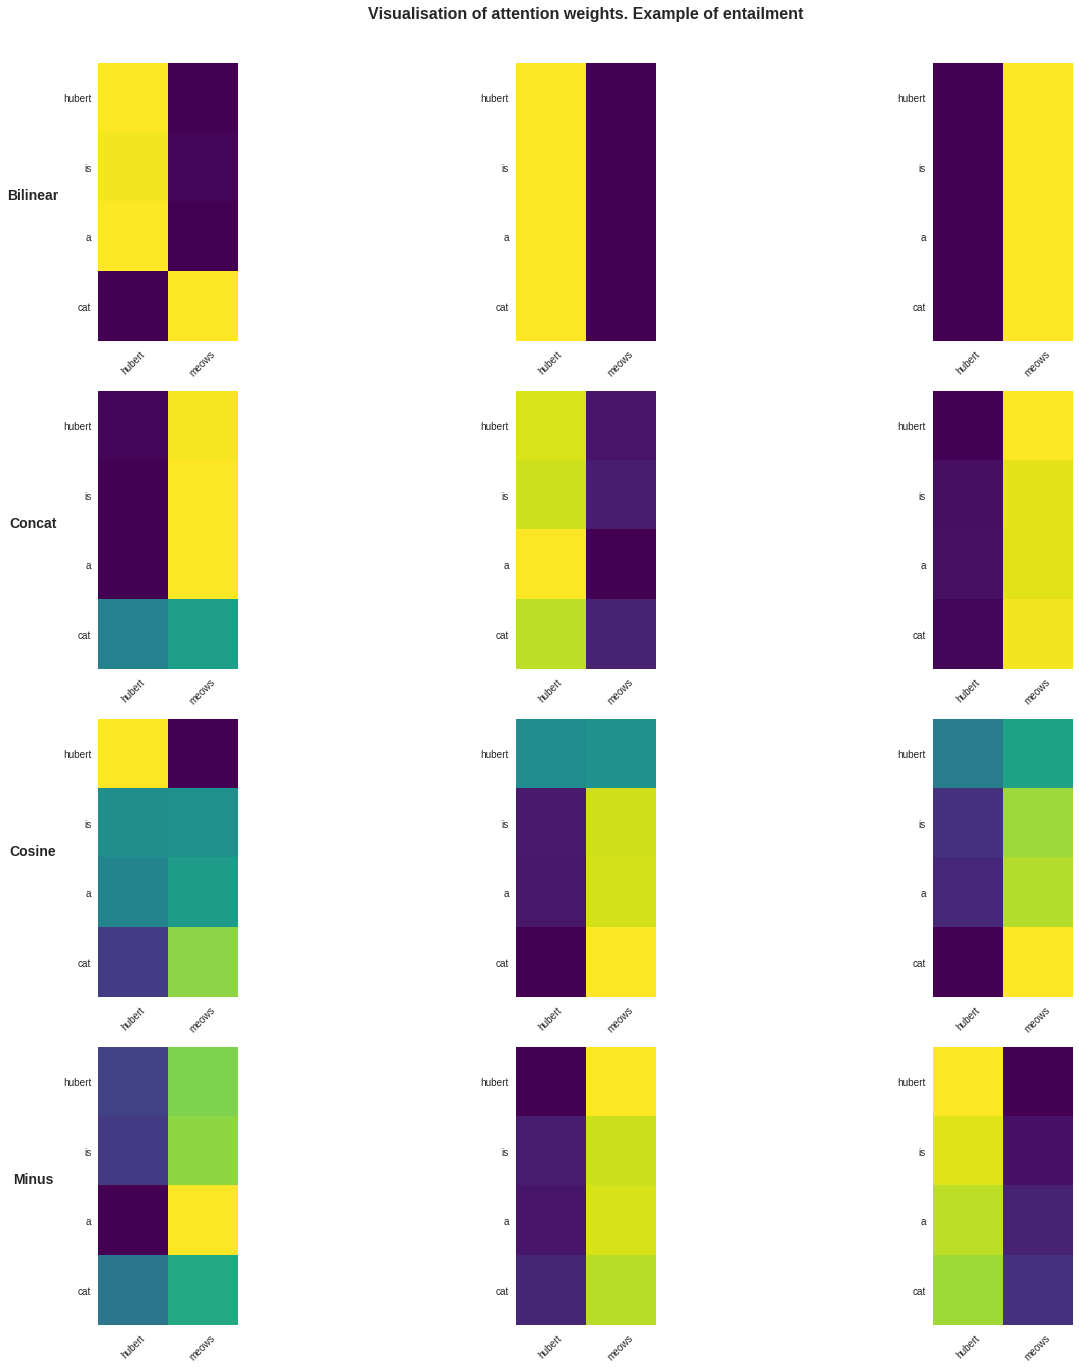

In [8]:
saved_batch = [input_ex[0], input_ex[2], attent, input_ex[-1]]
visualise_attention(saved_batch, 0, cmap = 'viridis')